# Test model

In [24]:
#hide_input
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lightgbm import LGBMRegressor


def normalize_features(X):
    """Normalisation robuste des features"""
    X_normalized = X.copy()
    for col in X_normalized.columns:
        X_normalized[col] = pd.to_numeric(X_normalized[col], errors='coerce')
        q1, q99 = X_normalized[col].quantile([0.01, 0.99])
        X_normalized[col] = X_normalized[col].clip(q1, q99)
        mean = X_normalized[col].mean()
        std = X_normalized[col].std()
        if std != 0:
            X_normalized[col] = (X_normalized[col] - mean) / std
        else:
            X_normalized[col] = 0
    return X_normalized

def preprocess_data(df):
    """Prétraitement complet des données"""
    # Copie et nettoyage initial
    df = df.copy()
    
    # Gestion des NaN
    nan_ratio = df.isna().sum() / len(df)
    columns_to_drop = nan_ratio[nan_ratio > 0.5].index
    df = df.drop(columns=columns_to_drop)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median())
    
    # Séparation features/target
    y = df['RT']
    X = df.drop(['Molecule_Name', 'RT'], axis=1)
    initial_features = X.shape[1]
    
    # Filtrage variance
    selector = VarianceThreshold(threshold=0.01)
    X_var = pd.DataFrame(selector.fit_transform(X), 
                        columns=X.columns[selector.get_support()])
    
    # Normalisation
    X_scaled = normalize_features(X_var)
    
    # Suppression corrélations
    corr_matrix = X_scaled.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    X_scaled = X_scaled.drop(to_drop, axis=1)
    
    return X_scaled.astype(np.float32), y, initial_features

def get_models():
    """Retourne les modèles à évaluer"""
    return {
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'LightGBM': LGBMRegressor(
            random_state=42,
            verbose=-1,  # Supprime tous les warnings
            min_child_samples=5,  # Minimum d'échantillons requis pour un nœud feuille
            min_data_in_leaf=5,  # Même chose que min_child_samples
            min_gain_to_split=0  # Gain minimum requis pour faire un split
        ),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }


Résultats pour descriptors_2D_LASSO (n_features=35):
--------------------------------------------------
Ridge           - CV R²: 0.776 (±0.033), Test R²: 0.643
Lasso           - CV R²: 0.560 (±0.023), Test R²: 0.368
RandomForest    - CV R²: 0.696 (±0.029), Test R²: 0.507
GradientBoosting - CV R²: 0.733 (±0.042), Test R²: 0.524
ExtraTrees      - CV R²: 0.742 (±0.016), Test R²: 0.532
XGBoost         - CV R²: 0.701 (±0.054), Test R²: 0.554
LightGBM        - CV R²: 0.725 (±0.037), Test R²: 0.550
SVR             - CV R²: 0.440 (±0.110), Test R²: 0.461
KNN             - CV R²: 0.538 (±0.028), Test R²: 0.436

Résultats pour descriptors_ECFP_LASSO (n_features=74):
--------------------------------------------------
Ridge           - CV R²: 0.573 (±0.059), Test R²: 0.054
Lasso           - CV R²: 0.172 (±0.042), Test R²: -0.050
RandomForest    - CV R²: 0.613 (±0.043), Test R²: 0.423
GradientBoosting - CV R²: 0.566 (±0.096), Test R²: 0.518
ExtraTrees      - CV R²: 0.370 (±0.210), Test R²: 0.117
X

ExtraTrees      - CV R²: 0.238 (±0.163), Test R²: 0.085
XGBoost         - CV R²: 0.337 (±0.178), Test R²: 0.059
LightGBM        - CV R²: 0.418 (±0.130), Test R²: 0.140
SVR             - CV R²: 0.518 (±0.062), Test R²: 0.281
KNN             - CV R²: 0.495 (±0.154), Test R²: 0.186

Résultats pour descriptors_MACCS_Boruta (n_features=15):
--------------------------------------------------
Ridge           - CV R²: 0.491 (±0.105), Test R²: -0.250
Lasso           - CV R²: 0.171 (±0.043), Test R²: -0.078
RandomForest    - CV R²: 0.486 (±0.114), Test R²: 0.172
GradientBoosting - CV R²: 0.398 (±0.092), Test R²: -0.120
ExtraTrees      - CV R²: 0.190 (±0.136), Test R²: -0.064
XGBoost         - CV R²: 0.403 (±0.125), Test R²: 0.046
LightGBM        - CV R²: 0.384 (±0.178), Test R²: 0.097
SVR             - CV R²: 0.422 (±0.093), Test R²: 0.157
KNN             - CV R²: 0.373 (±0.163), Test R²: 0.099

Résultats pour descriptors_MQN_Boruta (n_features=6):
-----------------------------------------------

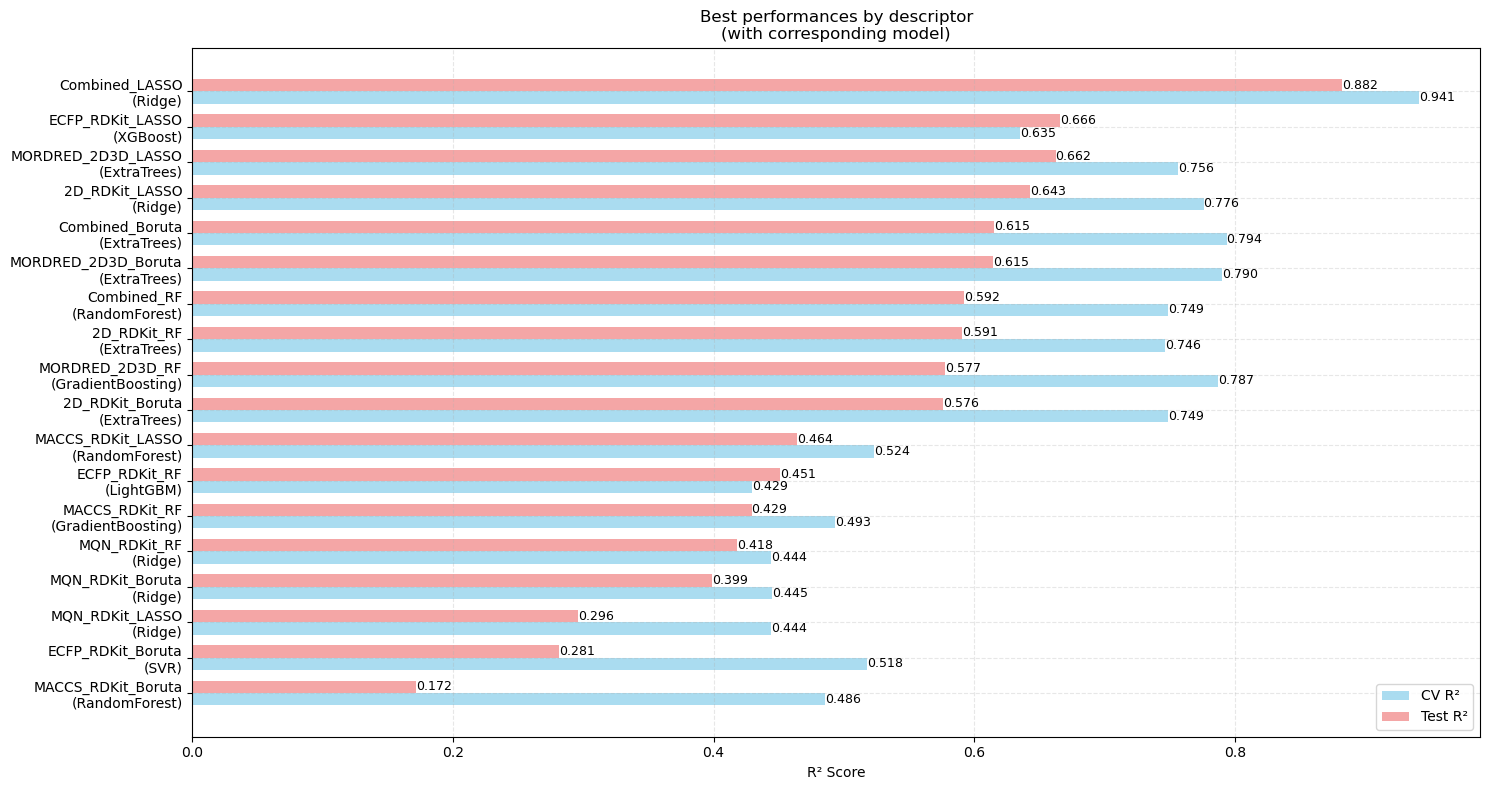


Meilleures performances CV:
                   Dataset             Model     CV_R2   Test_R2
45   all_descriptors_LASSO             Ridge  0.941171  0.882491
36   two_and_three_d_LASSO             Ridge  0.849541  0.513435
49   all_descriptors_LASSO        ExtraTrees  0.818921  0.584705
103     all_descriptors_RF        ExtraTrees  0.802497  0.540741
48   all_descriptors_LASSO  GradientBoosting  0.799332  0.553624

Meilleures performances Test:
                   Dataset       Model     CV_R2   Test_R2
45   all_descriptors_LASSO       Ridge  0.941171  0.882491
14  descriptors_ECFP_LASSO     XGBoost  0.635021  0.666108
40   two_and_three_d_LASSO  ExtraTrees  0.756455  0.662446
0     descriptors_2D_LASSO       Ridge  0.776029  0.642739
42   two_and_three_d_LASSO    LightGBM  0.697214  0.618777


In [ ]:
def evaluate_models(X, y, dataset_name):
    """Évalue tous les modèles sur un dataset"""
    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    results = {}
    print(f"\nRésultats pour {dataset_name} (n_features={X.shape[1]}):")
    print("-" * 50)
    
    for model_name, model in get_models().items():
        try:
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
            
            # Test set
            model.fit(X_train, y_train)
            test_score = model.score(X_test, y_test)
            
            results[model_name] = {
                'cv_r2_mean': cv_scores.mean(),
                'cv_r2_std': cv_scores.std(),
                'test_r2': test_score
            }
            
            print(f"{model_name:15} - CV R²: {cv_scores.mean():.3f} (±{cv_scores.std():.3f}), Test R²: {test_score:.3f}")
            
        except Exception as e:
            results[model_name] = {
                'cv_r2_mean': np.nan,
                'cv_r2_std': np.nan,
                'test_r2': np.nan
            }
            print(f"Erreur avec {model_name}: {str(e)}")
    
    return results


def plot_results(summary_df):
    """Synthetic visualization of best performances by descriptor"""
    # Créer le dossier figures/supervised s'il n'existe pas
    os.makedirs('figures/supervised', exist_ok=True)
    
    plt.figure(figsize=(15, 8))
    
    # Rename descriptors and keep the method
    descriptor_mapping = {
        'all_descriptors': 'Combined',
        'descriptors_ECFP': 'ECFP_RDKit', 
        'descriptors_2D': '2D_RDKit',
        'descriptors_MACCS': 'MACCS_RDKit',
        'descriptors_MQN': 'MQN_RDKit',
        'two_and_three_d': 'MORDRED_2D3D'
    }

    # Create a copy and map new names while keeping the method
    df_plot = summary_df.copy()
    
    # Separate descriptor name and method, then map the descriptor name
    df_plot['Method'] = df_plot['Dataset'].str.split('_').str[-1]  # Get method (LASSO/RF/Boruta)
    df_plot['Descriptor'] = df_plot['Dataset'].apply(lambda x: '_'.join(x.split('_')[:-1]))  # Get descriptor name
    df_plot['Descriptor'] = df_plot['Descriptor'].map(descriptor_mapping)
    # Combine mapped descriptor name with method
    df_plot['Dataset'] = df_plot['Descriptor'] + '_' + df_plot['Method']
    
    # Calculate best performances
    best_performances = (df_plot
        .sort_values('Test_R2', ascending=False)
        .groupby('Dataset')
        .agg({
            'Model': 'first',
            'Test_R2': 'max',
            'CV_R2': 'first'
        })
        .reset_index())
    
    # Sort by test performance
    best_performances = best_performances.sort_values('Test_R2', ascending=True)
    
    # Bar positions
    y_pos = np.arange(len(best_performances))
    width = 0.35
    
    # Create horizontal bars
    plt.barh(y_pos - width/2, best_performances['CV_R2'], width, 
             label='CV R²', color='skyblue', alpha=0.7)
    plt.barh(y_pos + width/2, best_performances['Test_R2'], width, 
             label='Test R²', color='lightcoral', alpha=0.7)
    
    # Add labels
    plt.yticks(y_pos, [f"{d}\n({m})" for d, m in zip(best_performances['Dataset'], 
                                                     best_performances['Model'])])
    
    # Customize plot
    plt.xlabel('R² Score')
    plt.title('Best performances by descriptor\n(with corresponding model)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add values on bars
    for i, (cv, test) in enumerate(zip(best_performances['CV_R2'], best_performances['Test_R2'])):
        plt.text(cv, i - width/2, f'{cv:.3f}', va='center', ha='left', fontsize=9)
        plt.text(test, i + width/2, f'{test:.3f}', va='center', ha='left', fontsize=9)
    
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    
    # Sauvegarder la figure
    plt.savefig('figures/supervised/best_performances.png', dpi=300, bbox_inches='tight')
    
    # Afficher la figure
    plt.show()

# Chargement et évaluation des données
data_dir = 'data/feature_selection/supervised'
methods = ['LASSO', 'RF', 'Boruta']
results = {}

for method in methods:
    for dataset in ['descriptors_2D', 'descriptors_ECFP', 'descriptors_MACCS', 
                   'descriptors_MQN', 'two_and_three_d', 'all_descriptors']:
        try:
            df = pd.read_parquet(f'{data_dir}/{dataset}_{method}.parquet')
            X_scaled, y, n_features = preprocess_data(df)
            
            dataset_name = f"{dataset}_{method}"
            results[dataset_name] = evaluate_models(X_scaled, y, dataset_name)
            
        except Exception as e:
            print(f"Error processing {dataset}_{method}: {str(e)}")

# Création du DataFrame de résultats
summary_data = []
for dataset_name, models_results in results.items():
    for model_name, scores in models_results.items():
        summary_data.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'CV_R2': scores['cv_r2_mean'],
            'Test_R2': scores['test_r2']
        })

summary_df = pd.DataFrame(summary_data)

# Affichage des résultats
plot_results(summary_df)

# Meilleures performances
print("\nMeilleures performances CV:")
print(summary_df.nlargest(5, 'CV_R2')[['Dataset', 'Model', 'CV_R2', 'Test_R2']])

print("\nMeilleures performances Test:")
print(summary_df.nlargest(5, 'Test_R2')[['Dataset', 'Model', 'CV_R2', 'Test_R2']])

# Sauvegarde des résultats
summary_df.to_csv('data/results/performance_summary.csv', index=False)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Meilleurs paramètres trouvés:
{'solver': 'saga', 'fit_intercept': True, 'alpha': 0.010722672220103232}

Meilleur score CV: 0.9536

Performances sur le test set:
R² Test: 0.9247
RMSE Test: 0.8301


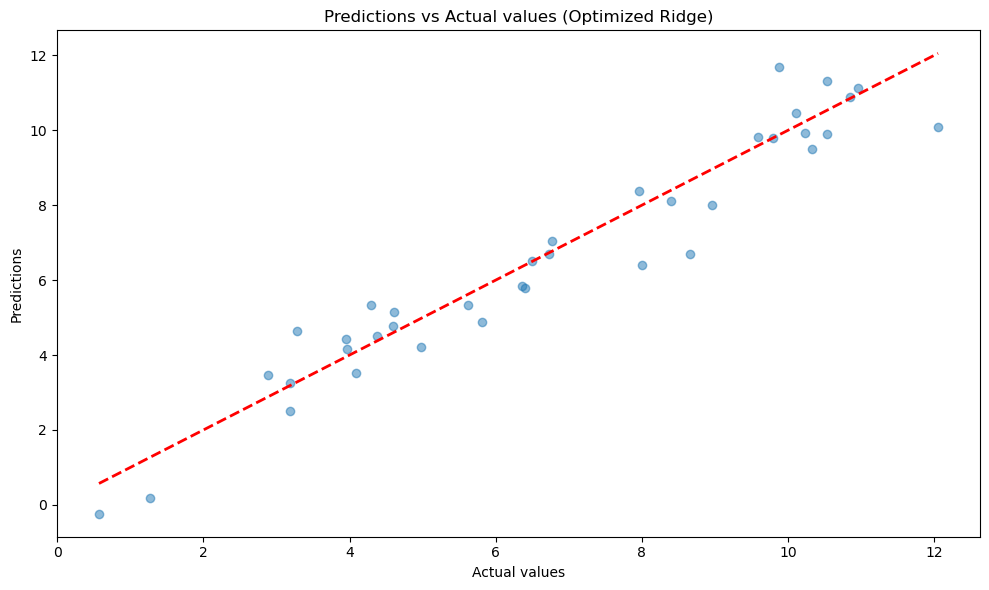

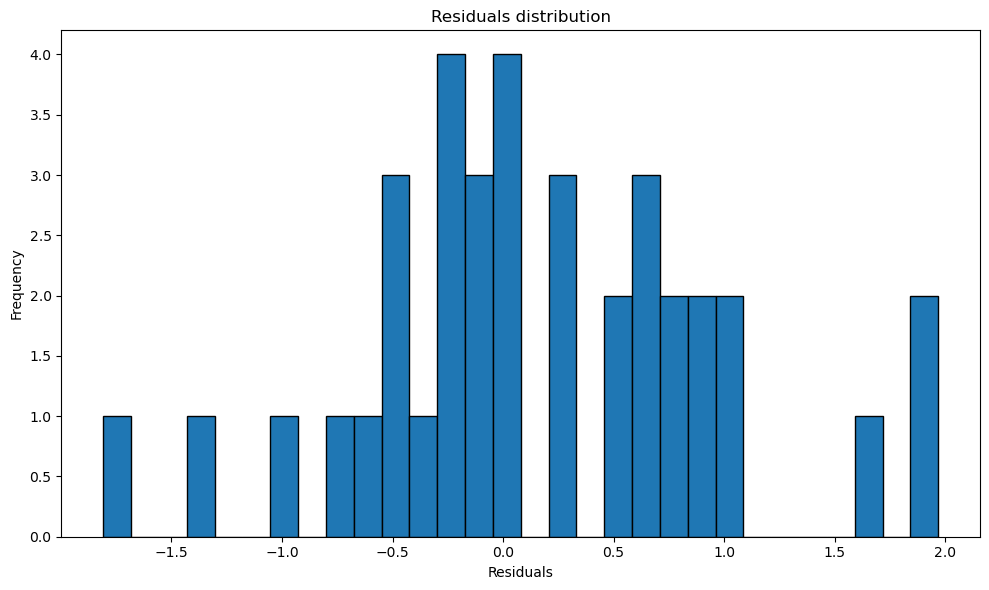

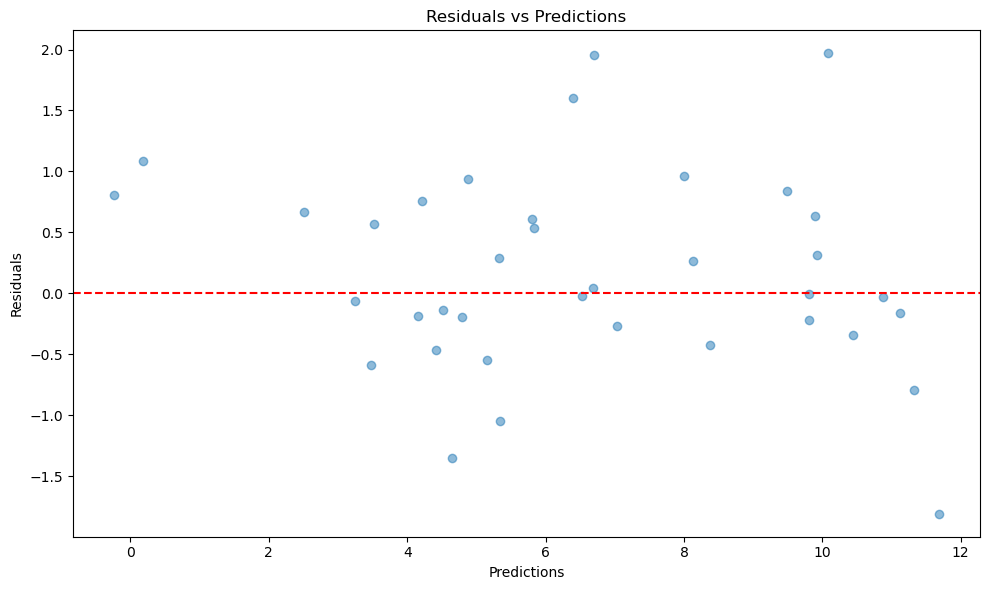


Statistiques des résidus:
Moyenne des résidus: 0.1664
Écart-type des résidus: 0.8133
Médiane des résidus: -0.0047


In [1]:
# Cellule pour l'optimisation du meilleur modèle
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import os
import pandas as pd

# Fonctions de prétraitement
def normalize_features(X):
    """Normalisation robuste des features"""
    X_normalized = X.copy()
    for col in X_normalized.columns:
        X_normalized[col] = pd.to_numeric(X_normalized[col], errors='coerce')
        q1, q99 = X_normalized[col].quantile([0.01, 0.99])
        X_normalized[col] = X_normalized[col].clip(q1, q99)
        mean = X_normalized[col].mean()
        std = X_normalized[col].std()
        if std != 0:
            X_normalized[col] = (X_normalized[col] - mean) / std
        else:
            X_normalized[col] = 0
    return X_normalized

def prepare_best_model(df):
    """Préparation des données avec la meilleure configuration"""
    # Prétraitement initial
    y = df['RT']
    X = df.drop(['Molecule_Name', 'RT'], axis=1)
    
    # Appliquer le même prétraitement
    selector = VarianceThreshold(threshold=0.01)
    X_var = pd.DataFrame(selector.fit_transform(X), 
                        columns=X.columns[selector.get_support()])
    X_scaled = normalize_features(X_var)
    
    return X_scaled, y

# Créer les dossiers nécessaires
os.makedirs('figures/results', exist_ok=True)

# Charger les données du meilleur modèle
df = pd.read_parquet('data/feature_selection/supervised/all_descriptors_LASSO.parquet')
X_scaled, y = prepare_best_model(df)

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Définition de la grille de paramètres pour Ridge
param_grid = {
    'alpha': np.logspace(-3, 3, 100),
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Optimisation avec RandomizedSearchCV
ridge_random = RandomizedSearchCV(
    Ridge(random_state=42),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Entraînement
ridge_random.fit(X_train, y_train)

# Meilleurs paramètres et scores
print("\nMeilleurs paramètres trouvés:")
print(ridge_random.best_params_)
print(f"\nMeilleur score CV: {ridge_random.best_score_:.4f}")

# Évaluation sur le test set
y_pred = ridge_random.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nPerformances sur le test set:")
print(f"R² Test: {test_r2:.4f}")
print(f"RMSE Test: {test_rmse:.4f}")

# Visualisation des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual values (Optimized Ridge)')
plt.tight_layout()
plt.savefig('figures/results/predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyse des résidus
residus = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residus, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals distribution')
plt.tight_layout()
plt.savefig('figures/results/residuals_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Résidus vs Prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residus, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.tight_layout()
plt.savefig('figures/results/residuals_vs_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Sauvegarde du modèle final
import joblib
os.makedirs('models', exist_ok=True)
joblib.dump(ridge_random.best_estimator_, 'models/ridge_all_descriptors_LASSO.joblib')
joblib.dump(X_scaled.columns, 'models/features_all_descriptors_LASSO.joblib')

# Affichage des statistiques des résidus
print("\nStatistiques des résidus:")
print(f"Moyenne des résidus: {np.mean(residus):.4f}")
print(f"Écart-type des résidus: {np.std(residus):.4f}")
print(f"Médiane des résidus: {np.median(residus):.4f}")

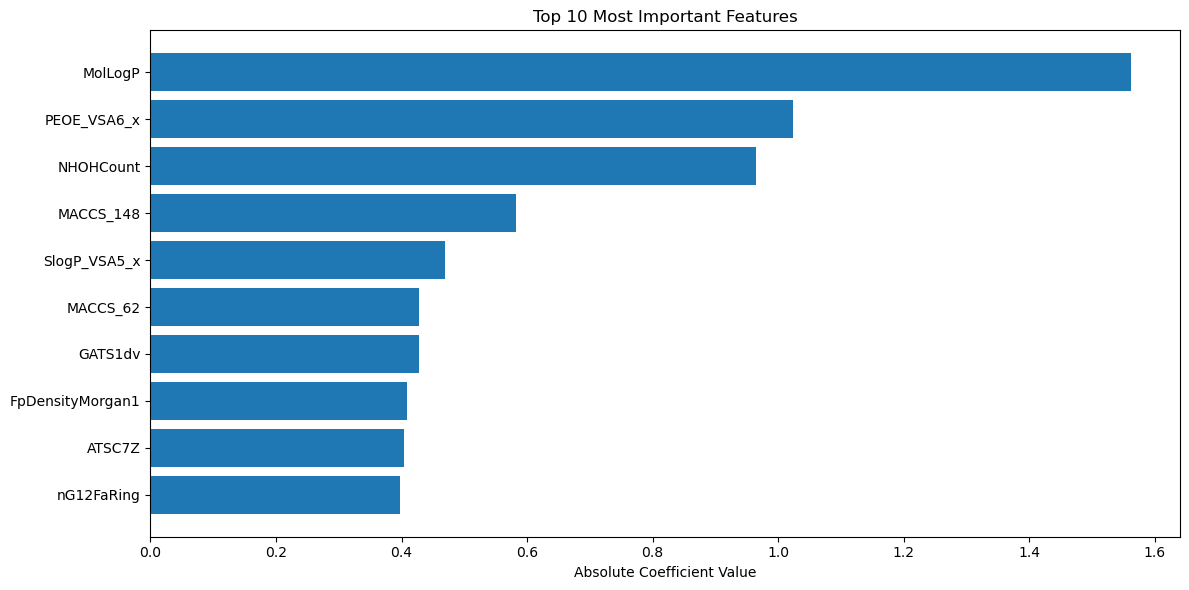


Top 10 features les plus importantes:
             feature  importance
8            MolLogP    1.562191
2        PEOE_VSA6_x    1.023339
7          NHOHCount    0.965476
64         MACCS_148    0.583077
5       SlogP_VSA5_x    0.468893
61          MACCS_62    0.428359
78           GATS1dv    0.428259
0   FpDensityMorgan1    0.409049
68            ATSC7Z    0.404588
90        nG12FaRing    0.397443


In [3]:

# Récupérer les coefficients du modèle
coef_importance = np.abs(ridge_random.best_estimator_.coef_)
feature_importance = pd.DataFrame({
   'feature': X_scaled.columns,
   'importance': coef_importance
})

# Trier par importance et prendre les 10 premiers
top_10_features = feature_importance.sort_values('importance', ascending=False).head(10)

# Visualisation des 10 features les plus importantes
plt.figure(figsize=(12, 6))
plt.barh(np.arange(len(top_10_features)), top_10_features['importance'])
plt.yticks(np.arange(len(top_10_features)), top_10_features['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Pour avoir la plus importante en haut
plt.tight_layout()
plt.savefig('figures/results/top_10_features.png', dpi=300, bbox_inches='tight')
plt.show()

# Si vous voulez afficher aussi les valeurs numériques
print("\nTop 10 features les plus importantes:")
print(top_10_features)